# **Simple Custom Digit Recognizer**

### **GROUP 10 : BAPTISTE ETROY, ASWIN SUBRAMANIAN MAHESWARAN, LARBI BENAMOUR**


## **Methodology**

### **1.EDA**

### **2. Building the Models**

**A. Machine Learning Model : Stacked Ensemble Approach**

**B. Machine Learning Model : XgBoost (Boosting Approach)**

**C. Multi-Layer Perceptron**

**D. Simple Convulutional Network**

### **3.Train the Models**

### **4. Cross‐Validation + Basic GridSearch HP Tuning**

### **5. Performance Reporting and Model Comparison**

### **6. Submission**

### **7. Challenges**

### **8. Model Explanation + Tech Stack**






#   **Code**

#   **1. EDA**

###  **A. Libraries**

### Pip Install Commands

In [68]:
# Commands to Run 
!pip install -U imbalanced-learn
!pip install --upgrade threadpoolctl
!pip install xgboost
!pip install bayesian-optimization



### Importing Libraries

In [69]:
import numpy as np 
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# Visualization
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

import random
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC, LinearSVC
from scipy.optimize import minimize
from sklearn import model_selection 
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate, train_test_split
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
import os

###  **B. Data Preparation**

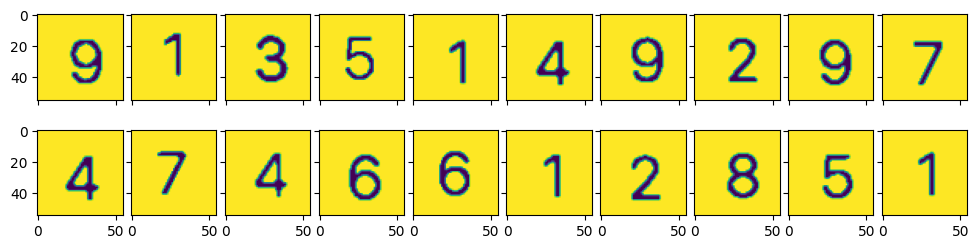

In [70]:
data = pd.read_csv("dataset_train.csv")

fig, ax = plt.subplots(2,10, figsize=(12, 3), sharex=True, sharey=True)
img_idx = np.random.choice(data.shape[0], 2*10)
for i, ax in enumerate(ax.flatten()):
    img = Image.fromarray(data.iloc[img_idx[i], :-1].values.reshape(55,-1).astype('uint8'))
    ax.imshow(img) # or ax.imshow(img, cmap='gray_r')

plt.subplots_adjust(hspace=0, wspace=0.1)    

plt.show()


###  **Split the data into training and testing sets**
X_train, X_test, y_train, y_test = train_test_split(df.drop("label", axis=1), df["label"], test_size=0.2, random_state=42)


In [71]:
data.shape

(1530, 3026)

In [72]:
if 'label' in data.columns:
    unique_types = data['label'].unique()
    print(f"The 'label' column has {len(unique_types)} unique types: {unique_types}")
else:
    print("The datasret does not have a 'label' column.")


The 'label' column has 10 unique types: [0 1 2 3 4 5 6 7 8 9]


In [73]:
last_column_name = data.columns[-1]
is_label = last_column_name == "label"
print(is_label)


True


In [74]:
data['label'].value_counts()

label
6    182
5    180
3    176
2    170
7    169
4    161
8    158
9    156
1    154
0     24
Name: count, dtype: int64

In [75]:

missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

print("Missing Values:")
print(missing_values)
print("\nMissing Percentage:")
print(missing_percentage)



Missing Values:
0        0
1        0
2        0
3        0
4        0
        ..
3021     0
3022     0
3023     0
3024     0
label    0
Length: 3026, dtype: int64

Missing Percentage:
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
3021     0.0
3022     0.0
3023     0.0
3024     0.0
label    0.0
Length: 3026, dtype: float64


In [76]:
missing_values = data.isnull().sum()
cols_missing_values = missing_values[missing_values > 0].index.tolist()
print(cols_missing_values)

[]


###  **C. Visual Inspection**

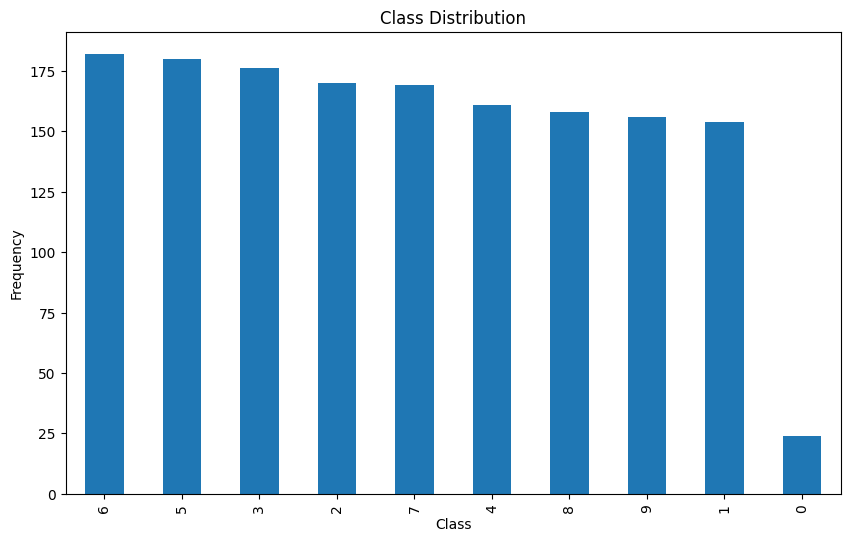

In [77]:

class_counts = data.iloc[:, -1].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


*    **The class ( '0' on the x-axis) is  underrepresented compared to the others.**


*    **Possible Approach : Oversampling the minority class, where we increase the number of samples in the minority class (0 label in your case) by randomly replicating  some of the instances.**

In [78]:
num_feature_columns = data.shape[1] - 1
pos_dim = int(np.sqrt(num_feature_columns))

if pos_dim * pos_dim == num_feature_columns:
    img_dim = (pos_dim, pos_dim)
    print(f"The dataset has {num_feature_columns} feature columns, which can be reshaped into images of dimensions {img_dim}.")
else:
    raise ValueError("The number of columns in the dataset is not a perfect square.")


The dataset has 3025 feature columns, which can be reshaped into images of dimensions (55, 55).


###  **D. Feature Distributions**


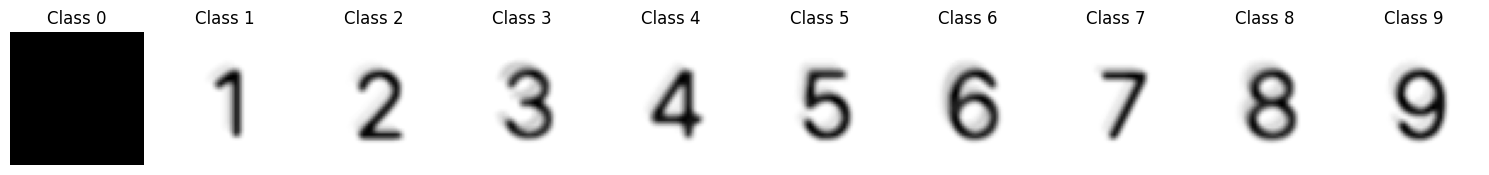

In [79]:
num_features = data.shape[1] - 1  # number of features
num_classes = data.iloc[:, -1].nunique()  # number of unique classes (digits)

if int(np.sqrt(num_features)) ** 2 != num_features:
    raise ValueError("Number of features is not a perfect square, cannot infer image dimensions.")

# the images are 55x55 pixels
image_shape = (int(np.sqrt(num_features)), int(np.sqrt(num_features)))

# Initialize a plot
fig, axes = plt.subplots(1, num_classes, figsize=(15, 15))

# A Plot for Average Class
for i in range(num_classes):
    class_data = data[data.iloc[:, -1] == i].iloc[:, :-1]
    
    mean_image = class_data.mean(axis=0).values.reshape(image_shape)
    
    ax = axes[i]
    ax.imshow(mean_image, cmap='gray')
    ax.axis('off')  
    ax.set_title(f'Class {i}')

plt.tight_layout()
plt.show()

###     Analysing Class 0

In [80]:
class_0_data = data[data.iloc[:, -1] == 0].iloc[:, :-1]  
pixel_value_range = class_0_data.max().max(), class_0_data.min().min() 
print(f"Pixel value range for Class 0: {pixel_value_range}")

Pixel value range for Class 0: (255, 255)


### Visualising Several Individual Samples from Class 0. 


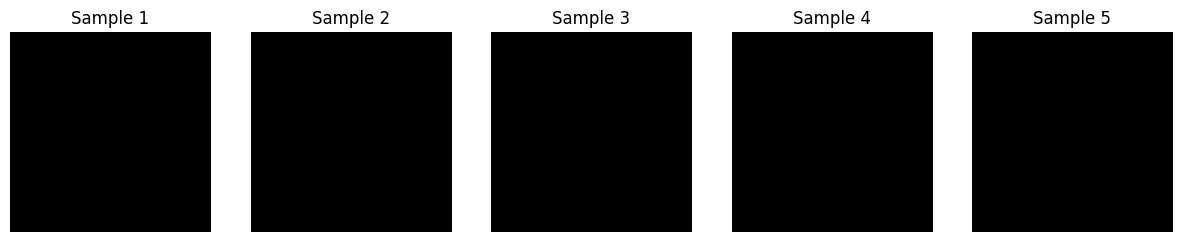

In [81]:
samples_visual = 5
fig, axes = plt.subplots(1, samples_visual, figsize=(15, 3))

for i, ax in enumerate(axes.flat):

    idx = random.choice(class_0_data.index)
    image = class_0_data.loc[idx].values.reshape(image_shape)
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Sample {i+1}')

plt.show()


In [82]:
print("First few feature columns:", data.columns[:10])
print("Last few feature columns:", data.columns[-10:-1]) 

First few feature columns: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')
Last few feature columns: Index(['3016', '3017', '3018', '3019', '3020', '3021', '3022', '3023', '3024'], dtype='object')


###  **E. Using PCA for Dimensionality Reduction**


In [83]:

X = data.iloc[:, :-1]
y = data.iloc[:, -1]


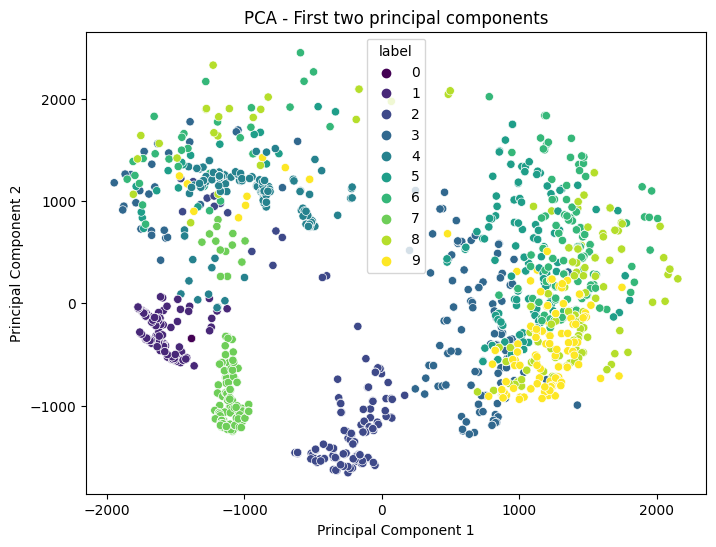

In [84]:
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, legend='full', palette='viridis')
plt.title('PCA - First two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


*   **Overlap** - The overlap among labels 5 through 9 in the PCA plot suggests these digits have similar variance and are not  distinguishable in the transformed feature space provided in first two principal components.

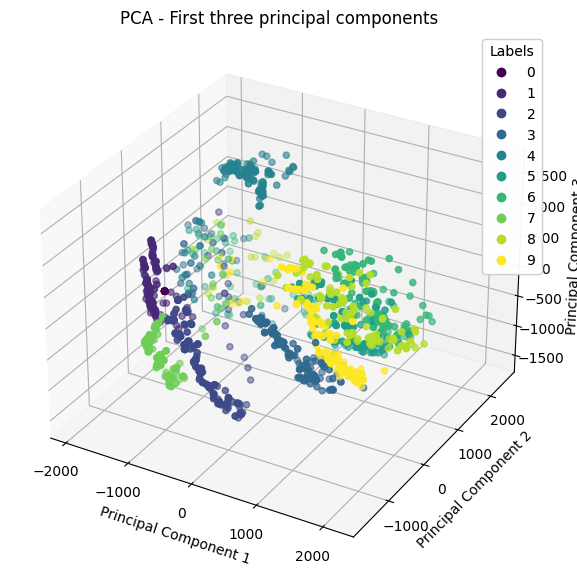

In [85]:

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)  

#  a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

legend = ax.legend(*scatter.legend_elements(), loc="best", title="Labels")
ax.add_artist(legend)

plt.title('PCA - First three principal components')

#  plot
plt.show()


*   **Insights** - The 3D PCA plot indicates the separation of classes in the first three principal components. There's some degree of clustering by class, but there is also reasonable overlap between classes, particularly in the center of the plot.

#  **2. Insights into Model Building Stage**

**Non-Linear Models** : Since there’s a overlap of features, non-linear ones will capture complex patterns and relationships in data. 

**CNN** : For image data, CNNs will help capture spatial hierarchies and patterns within the images which are not evident from the PCA plot.



In [86]:

X = data.iloc[:, :-1]
y = data.iloc[:, -1]


###  **a. Over Sampling Technique**

In [87]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import pandas as pd

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print(pd.Series(y_resampled).value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


label
0    182
1    182
2    182
3    182
4    182
5    182
6    182
7    182
8    182
9    182
Name: count, dtype: int64


In [88]:
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of y_test is {y_test.shape}")

The shape of X_train is (1456, 3025)
The shape of y_train is (1456,)
The shape of X_test is (364, 3025)
The shape of y_test is (364,)


#    **3. Model Building**

## **A. Model 1 (Machine Learning Model) - Ensemble Technique**

* **Best parameters found from HP Tuning with GridSearchCV:** 

    1. SVC Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

    2. Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

    3. KNN Best parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}

Cross-validated accuracy scores: [1.         1.         0.99656357 0.99656357 0.9862543 ]
Mean cross-validated accuracy: 0.9958762886597938
Ensemble test accuracy: 0.9972527472527473
Ensemble Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        35
           2       1.00      0.98      0.99        41
           3       1.00      1.00      1.00        42
           4       1.00      1.00      1.00        34
           5       1.00      1.00      1.00        34
           6       1.00      1.00      1.00        22
           7       0.97      1.00      0.99        39
           8       1.00      1.00      1.00        44
           9       1.00      1.00      1.00        34

    accuracy                           1.00       364
   macro avg       1.00      1.00      1.00       364
weighted avg       1.00      1.00      1.00       364



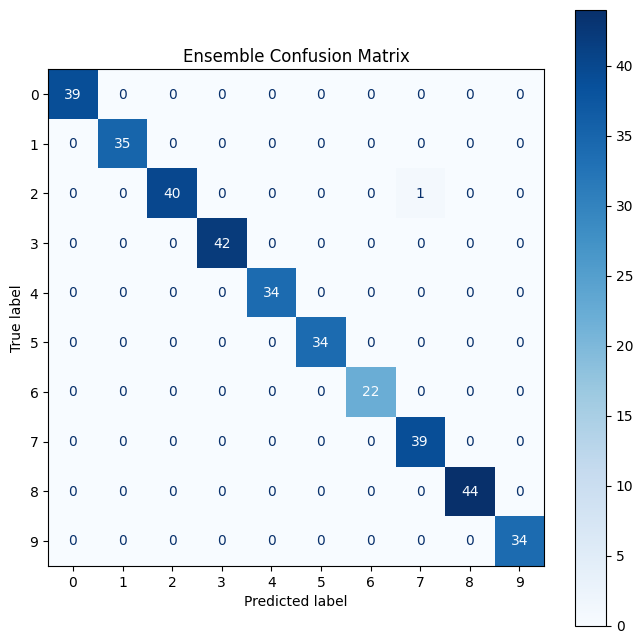

In [89]:
from sklearn.metrics import top_k_accuracy_score

best_rf = RandomForestClassifier(
    n_estimators=500, 
    max_depth=None, 
    min_samples_leaf=1, 
    min_samples_split=2,
    random_state=42
)

best_svc = SVC(
    C=1, 
    gamma='scale', 
    kernel='rbf', 
    probability=True
)

best_knn = KNeighborsClassifier(
    algorithm='auto', 
    n_neighbors=5, 
    weights='distance'
)

# Fit the models
best_rf.fit(X_train, y_train)
best_svc.fit(X_train, y_train)
best_knn.fit(X_train, y_train)

ensemble_model = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('svc', best_svc),
        ('knn', best_knn)
    ],
    voting='soft',
    # weights = [1, 1, 1] 
    # Started with equal weights, but rf performed better  compared to Knn and SVC, so I increased the weight of rf. 
    weights=[3, 1, 1]  
)
# 5-Fold Cross Validation
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validated accuracy scores: {cv_scores}")
print(f"Mean cross-validated accuracy: {cv_scores.mean()}")

ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)

# ensemble model
print(f"Ensemble test accuracy: {accuracy_score(y_test, y_pred_ensemble)}")
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

# confusion matrix
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ensemble)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Ensemble Confusion Matrix")
plt.show()

In [90]:
import joblib

filename = 'ML_A.sav'
joblib.dump(ensemble_model, filename)

['ML_A.sav']

ensemble_model

## **B.    Model 2 (Machine Learning Model) - XgBoost**

###     **Insights**

*   **The initial model was performing quite well, with a low log loss of 0.027.**

*   **The first iteration of hyperparameter tuning using GridSearchCV improved the model's performance, reducing  log loss to 0.023 and increasing the accuracy to 99.45%.**

*   **The second round of tuning using Bayesian Optimization did not improve the model as much as the first iteration, resulting in a high log loss of 0.08.**

*   **Why multi:softprob is a good choice for Xgboost in a multi-class classification model?**

* **Best parameters found from HP Tuning + GridSearchCV:** 

    {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8}


Fold 1: Accuracy = 0.9945, Log Loss = 0.0242
Fold 2: Accuracy = 0.9973, Log Loss = 0.0145
Fold 3: Accuracy = 0.9918, Log Loss = 0.0489
Fold 4: Accuracy = 0.9863, Log Loss = 0.0394
Fold 5: Accuracy = 0.9835, Log Loss = 0.0707

Best Fold: 2
Best Fold Accuracy: 0.9973
Best Fold Log Loss: 0.0145

Classification Report for Best Fold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.98      1.00      0.99        43
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        34
           4       1.00      0.97      0.99        39
           5       1.00      1.00      1.00        30
           6       1.00      1.00      1.00        38
           7       1.00      1.00      1.00        36
           8       1.00      1.00      1.00        35
           9       1.00      1.00      1.00        47

    accuracy                           1.00       364
   macro avg       

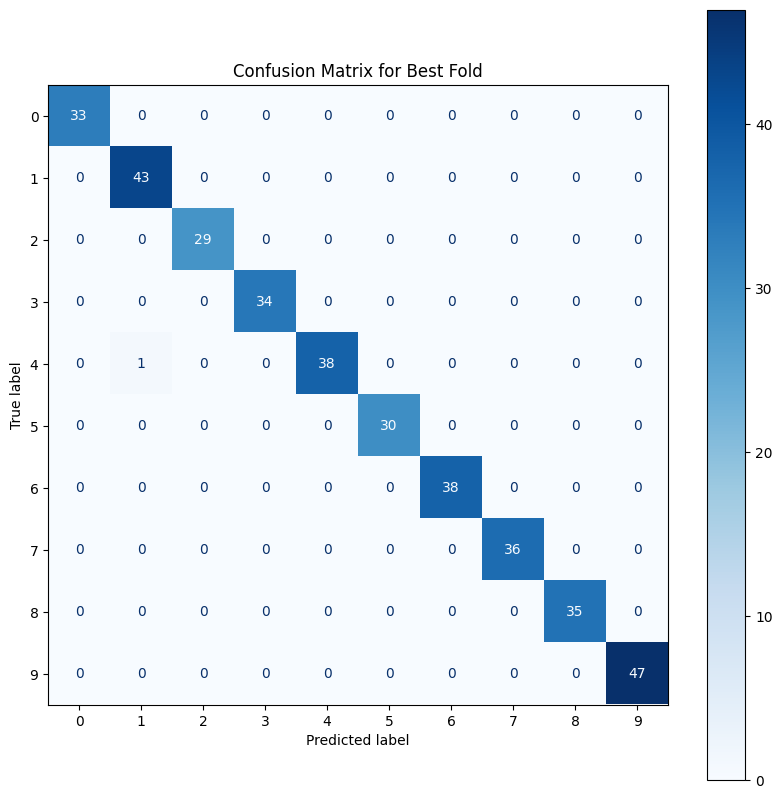

In [91]:

best_params = {
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'colsample_bytree': 0.8,
    'learning_rate': 0.2,
    'max_depth': 8,
    'n_estimators': 300,
    'subsample': 0.8,
    'random_state': 42
}

best_model = XGBClassifier(**best_params)

best_accuracy = 0
best_logloss = np.inf
best_fold_index = -1

#  K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#  K-Fold CV to find the best subset
for i, (train_index, test_index) in enumerate(kf.split(X_resampled)):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # Train the model and fit it on the training data
    best_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_proba)
    
    print(f"Fold {i+1}: Accuracy = {accuracy:.4f}, Log Loss = {logloss:.4f}")
    
    #  Check if the current fold is the best so far. 
    if logloss < best_logloss:
        best_logloss = logloss
        best_accuracy = accuracy
        best_fold_index = i
        best_y_test = y_test
        best_y_pred = y_pred


# Output for the best fold and its eval metrices
print(f"\nBest Fold: {best_fold_index+1}")
print(f"Best Fold Accuracy: {best_accuracy:.4f}")
print(f"Best Fold Log Loss: {best_logloss:.4f}")

if best_y_test is not None and best_y_pred is not None:
    print("\nClassification Report for Best Fold:")
    print(classification_report(best_y_test, best_y_pred))
    
    conf_matrix = confusion_matrix(best_y_test, best_y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))  
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_resampled))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title("Confusion Matrix for Best Fold")
    plt.show()



In [92]:
import joblib

filename = 'ML_B.sav'
joblib.dump(best_model, filename)

['ML_B.sav']

### **Benchmark for ML Models A & B.**

**1. Accuracy**

**2. Log-Loss**

**3. Classification Report**

**4. Confusion Matrix.**




## **C. Model 3 : Multi‐layer Perceptron**

In [93]:
import tensorflow as tf
tf.test.gpu_device_name()


2024-04-08 15:07:14.969933: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-08 15:07:14.969960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'/device:GPU:0'

In [94]:
from tensorflow.keras.utils import to_categorical
import numpy as np

* **Converting the labels into a one-hot vector**

The labels are in digit format ranging from 0 to 9. This is called the sparse scalar representation of labels. It is not suitable for the neural network output layer that outputs probabilities per class.

The one-hot vector (in this case, it is a 10-dimensional vector) is a more suitable format for the neural network output layer.

We can use the tf.Keras to_categorical() function to convert each label into a one-hot vector.



In [95]:
np.random.seed(42)
tf.random.set_seed(42)

In [96]:

y_one_hot = to_categorical(y_resampled)


In [97]:
y_one_hot.shape

(1820, 10)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_one_hot, test_size=0.2, random_state=42)

In [99]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)


In [100]:
print(f"The shape of X_train is {X_train_norm.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of X_test is {X_test_norm.shape}")
print(f"The shape of y_test is {y_test.shape}")


The shape of X_train is (1456, 3025)
The shape of y_train is (1456, 10)
The shape of X_test is (364, 3025)
The shape of y_test is (364, 10)


In [101]:
y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Text(0, 0.5, 'Explained variance')

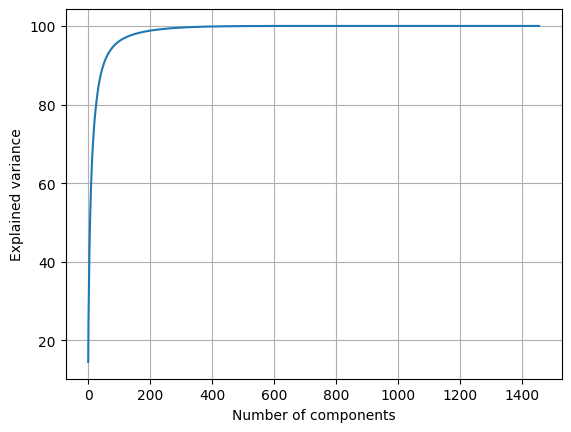

In [102]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_1456 = PCA(n_components=1456)
pca_1456.fit(X_train_norm)

plt.grid()
plt.plot(np.cumsum(pca_1456.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

We can see that the first 350 components capture close betweeen 90%-100% of the variability in the original image data. That is enough to retain the quality of the original images. So, we select the first 350 components and apply PCA again with that number of selected components

In [103]:
pca_350 = PCA(n_components=350)
pca_350.fit(X_train_norm)
X_train_pca = pca_350.transform(X_train_norm)
X_test_pca = pca_350.transform(X_test_norm)

# verify shape after PCA
print("Train images shape:", X_train_pca.shape)
print("Test images shape: ", X_test_pca.shape)

# get exact variability retained
print("\nVar retained (%):", 
      np.sum(pca_350.explained_variance_ratio_ * 100))

Train images shape: (1456, 350)
Test images shape:  (364, 350)

Var retained (%): 99.74836130029573


### **Hyperparameters from Tuning + Hyperopt [Bayesian Optimization]** (Code in hp_tuning notebook)

1. **Hyperparameter**: Using hyperopt, we define the range and possible values of hyperparameters to explore, which includes the number of neurons, layer sizes, dropout rates, and regularization factors.


2. **Objective Function**: We created a function which takes hyperparameters as input, builds and trains a Keras model on the data, and then returns the validation loss as the metric to minimize.


3. **Optimization**: Hyperopt's fmin function searches through hyperparameter space, using the Tree of Parzen Estimators (TPE) algorithm, and determines the set of hyperparameters which result in the lowest validation loss.



* After HP tuning I found out these are my best params 

    {
    
    'batch_size': 153.0, 

    'dropout_1': 0.315466728419895, 

    'dropout_2': 0.30135162620408623, 

    'dropout_3': 0.3142666529964194, 

    'l2_1': 3.850837414921736e-05, 

    'l2_2': 4.4023809916155655e-05, 

    'l2_3': 0.0002966538783423139, 

    'optimizer': 0, 

    'units1': 41.0, 

    'units2': 50.0, 
    
    'units3': 57.0
    
    }


In [150]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay



In [192]:
# Hyperparameters from tuning

batch_size = int(153.0)
dropout_1 = 0.315466728419895
dropout_2 = 0.30135162620408623
dropout_3 = 0.3142666529964194
l2_1 = 3.850837414921736e-05
l2_2 = 4.4023809916155655e-05
l2_3 = 0.0002966538783423139
units1 = int(41)
units2 = int(50)
units3 = int(57)
optimizer = 'adam'  # index 0 refers to adam
initial_learning_rate = 0.001  #  learning rate
decay_steps = 1000  # Number of steps to decay over
decay_rate = 0.96  # Decay rate


###     **Define Neural Network Architecture** (need to explain here)


In [189]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.regularizers import l2

MLP = Sequential([
    InputLayer(input_shape=(3025, )),  
    Dense(units=units1, activation='relu', kernel_regularizer=l2(l2_1)),
    Dropout(dropout_1),
    Dense(units=units2, activation='relu', kernel_regularizer=l2(l2_2)),
    Dropout(dropout_2),
    Dense(units=units3, activation='relu', kernel_regularizer=l2(l2_3)),
    Dropout(dropout_3),
    Dense(10, activation='softmax')  
])

MLP.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 41)                124066    
                                                                 
 dropout_37 (Dropout)        (None, 41)                0         
                                                                 
 dense_49 (Dense)            (None, 50)                2100      
                                                                 
 dropout_38 (Dropout)        (None, 50)                0         
                                                                 
 dense_50 (Dense)            (None, 57)                2907      
                                                                 
 dropout_39 (Dropout)        (None, 57)                0         
                                                                 
 dense_51 (Dense)            (None, 10)              

**Optimization**

MLP.compile(loss='categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

In [193]:
MLP.compile(loss='categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

In [194]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Callbacks

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(filepath='HP_Tuning/best_model.h5', monitor='val_loss', save_best_only=True)]


*   No.of Epochs : 500

*   With X_train & X_test norm 



In [195]:
# train (fit)

history = MLP.fit(X_train_norm, y_train, 
                  epochs=50, 
                  batch_size=batch_size, 
                  verbose=1,
                  validation_split=0.15, 
                  callbacks=callbacks)



Epoch 1/50
1/9 [==>...........................] - ETA: 2s - loss: 3.0736 - accuracy: 0.1176

2024-04-08 15:22:26.520832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 60ms/step - loss: 2.3055 - accuracy: 0.2999 - val_loss: 0.9989 - val_accuracy: 0.8037
Epoch 2/50
1/9 [==>...........................] - ETA: 0s - loss: 1.7643 - accuracy: 0.5033

2024-04-08 15:22:27.059280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 32ms/step - loss: 1.6057 - accuracy: 0.5247 - val_loss: 0.5616 - val_accuracy: 0.9132
Epoch 3/50
9/9 [==============================] - 0s 29ms/step - loss: 1.3075 - accuracy: 0.6540 - val_loss: 0.4486 - val_accuracy: 0.9406
Epoch 4/50
9/9 [==============================] - 0s 27ms/step - loss: 1.1805 - accuracy: 0.6944 - val_loss: 0.3391 - val_accuracy: 0.9452
Epoch 5/50
9/9 [==============================] - 0s 27ms/step - loss: 0.9825 - accuracy: 0.7591 - val_loss: 0.3148 - val_accuracy: 0.9452
Epoch 6/50
9/9 [==============================] - 0s 25ms/step - loss: 0.9082 - accuracy: 0.7680 - val_loss: 0.2721 - val_accuracy: 0.9635
Epoch 7/50
9/9 [==============================] - 0s 27ms/step - loss: 0.9018 - accuracy: 0.7793 - val_loss: 0.2193 - val_accuracy: 0.9680
Epoch 8/50
9/9 [==============================] - 0s 27ms/step - loss: 0.8145 - accuracy: 0.8133 - val_loss: 0.1998 - val_accuracy: 0.9543
Epoch 9/50
9/9 [======================

In [196]:

test_loss, test_acc = MLP.evaluate(X_test_norm, y_test,
                                   batch_size=batch_size,
                                   verbose=0)

Test loss: 0.32863667607307434
Test accuracy: 0.9917582273483276


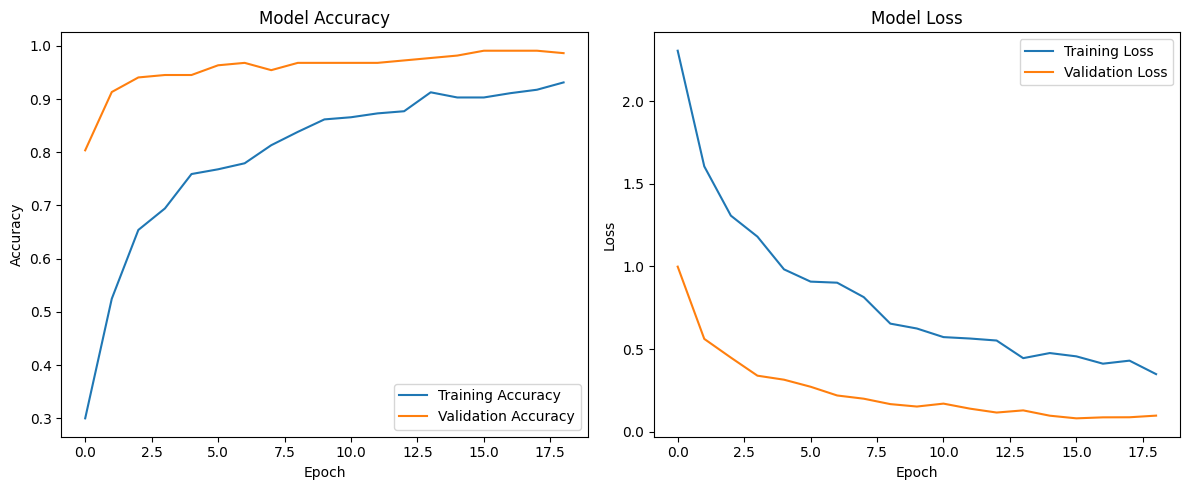

In [197]:
# Evaluating with Visual Info

print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        35
           2       1.00      0.93      0.96        41
           3       0.95      1.00      0.98        42
           4       1.00      1.00      1.00        34
           5       1.00      1.00      1.00        34
           6       0.96      1.00      0.98        22
           7       1.00      1.00      1.00        39
           8       1.00      1.00      1.00        44
           9       1.00      1.00      1.00        34

    accuracy                           0.99       364
   macro avg       0.99      0.99      0.99       364
weighted avg       0.99      0.99      0.99       364

Log loss: 0.07063700925750206
Confusion Matrix:
 [[39  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  0  0]
 [ 0  0 38  2  0  0  1  0  0  0]
 [ 0  0  0 42  0  0  0  0  0  0]
 [ 0  0

2024-04-08 15:23:00.426166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


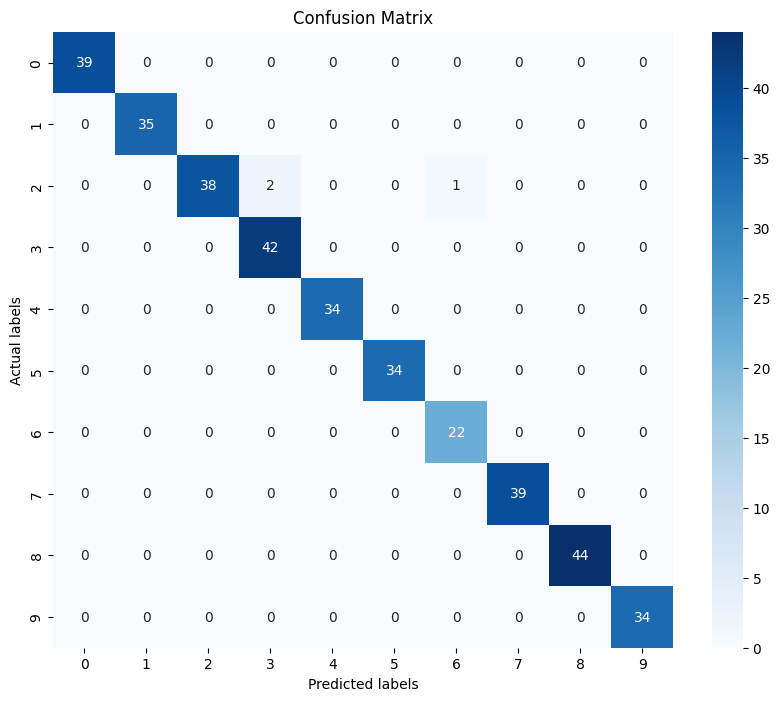

In [198]:
y_pred_probs = MLP.predict(X_test_norm)

y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

#  the classification report
print(classification_report(y_true_classes, y_pred_classes))

#  log loss
loss = log_loss(y_test, y_pred_probs)
print(f"Log loss: {loss}")

#  the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

In [114]:
import joblib

filename = 'MLP_Model.sav'
joblib.dump(MLP, filename)

['MLP_Model.sav']

## **D. Model 4 : Simple Convolutional Network**

###     Tensorflow Approach

In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


In [116]:

X_train_res = X_train_norm.reshape(-1, 3025, 1)  
X_test_res = X_test_norm.reshape(-1, 3025, 1)


In [117]:
# Verify new shape
print(" Train images:", X_train_res.shape)
print(" Test images: ", X_test_res.shape)

 Train images: (1456, 3025, 1)
 Test images:  (364, 3025, 1)


### **Hyperparameters from Tuning + Hyperband [Keras Tuner Library]** (Code in hp_tuning notebook)


1. **Efficiency**: Identifies the most promising hyperparameter sets by allocating resources to the ones which are reducing the loss function, speeding up the tuning process.



2. **Adaptability**: Handles large hyperparameter space of CNNs, ensuring optimal model configurations are found.



3. **Resource Optimization**: Eliminates least performing configurations while dedicating more resources to promising ones which saves computational time and resources.







###   **Results of HP Tuning**

**Trial 30 Complete [00h 00m 12s]**

    val_accuracy: 0.9726027250289917

    Best val_accuracy: 0.9794520735740662

**Total elapsed time: 00h 02m 34s:**


    The optimal number of filters for the first convolutional layer is 96.

    The optimal kernel size for the first convolutional layer is 5.

    The optimal dropout rate after the first convolutional layer is 0.3.

    The optimal number of filters for the second convolutional layer is 128.

    The optimal kernel size for the second convolutional layer is 3.

    The optimal dropout rate after the second convolutional layer is 0.5.

    The optimal number of units in the dense layer is 128.

    The optimal dropout rate before the output layer is 0.5.

    The optimal learning rate for the optimizer is 0.001028124409184032.




### **Defining the Model Architecture**

In [118]:
# Defining the model architecture
 
model = Sequential([
    Conv1D(96, 5, activation='relu', input_shape=(3025, 1)),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),

    
    Conv1D(128, 3, activation='relu'),  # Additional Convolutional Layer
    MaxPooling1D(2),
    Dropout(0.5),  # Maintaining high dropout to combat potential overfitting
    
    Flatten(),
    Dense(256, activation='relu'),  # Increased complexity in the dense layer
    Dropout(0.5),
    
    Dense(10, activation='softmax')
])


At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.

In [119]:
from tensorflow.keras.optimizers import legacy

model.compile(optimizer=legacy.Adam(learning_rate=0.001028124409184032),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [120]:
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Learning rate schedule function
def lr_time_based_decay(epoch, lr):
    decay = epoch / 20  
    return lr * 1 / (1 + decay)

# LearningRateScheduler + callbacks
callbacks = [
    LearningRateScheduler(lr_time_based_decay, verbose=1),
]

history = model.fit(X_train_res, y_train, 
                             epochs=300, 
                             batch_size=128, 
                             validation_split=0.2, 
                             callbacks=callbacks)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010281243594363332.
Epoch 1/300


2024-04-08 15:07:22.754548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 2s 112ms/step - loss: 1.2310 - accuracy: 0.6177 - val_loss: 0.4229 - val_accuracy: 0.9486 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009791660566060316.
Epoch 2/300


2024-04-08 15:07:23.968864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 72ms/step - loss: 0.3978 - accuracy: 0.9201 - val_loss: 0.3185 - val_accuracy: 0.9692 - lr: 9.7917e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008901509202339432.
Epoch 3/300
10/10 [==============================] - 1s 75ms/step - loss: 0.2375 - accuracy: 0.9562 - val_loss: 0.2600 - val_accuracy: 0.9795 - lr: 8.9015e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000774044260058714.
Epoch 4/300
10/10 [==============================] - 1s 71ms/step - loss: 0.1198 - accuracy: 0.9777 - val_loss: 0.3203 - val_accuracy: 0.9795 - lr: 7.7404e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006450368770553421.
Epoch 5/300
10/10 [==============================] - 1s 70ms/step - loss: 0.0949 - accuracy: 0.9863 - val_loss: 0.2712 - val_accuracy: 0.9760 - lr: 6.4504e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0005160294938832521.
Epoch 6/300
10/10 [==============================] - 1s 7

In [121]:
test_loss, test_accuracy = model.evaluate(X_test_res, y_test)
print(f" Test Loss: {test_loss}")
print(f" Test Accuracy: {test_accuracy}")


12/12 [==============================] - 0s 13ms/step - loss: 0.0957 - accuracy: 0.9945
 Test Loss: 0.09568122029304504
 Test Accuracy: 0.9945054650306702


12/12 [==============================] - 0s 10ms/step


2024-04-08 15:10:52.494470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        35
           2       1.00      0.98      0.99        41
           3       0.98      1.00      0.99        42
           4       1.00      1.00      1.00        34
           5       1.00      1.00      1.00        34
           6       0.96      1.00      0.98        22
           7       1.00      1.00      1.00        39
           8       1.00      0.98      0.99        44
           9       1.00      1.00      1.00        34

    accuracy                           0.99       364
   macro avg       0.99      1.00      0.99       364
weighted avg       0.99      0.99      0.99       364

Log loss: 0.0645
Confusion Matrix:
 [[39  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  0  0]
 [ 0  0 40  1  0  0  0  0  0  0]
 [ 0  0  0 42  0  0  0  0  0  0]
 [ 0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0]
 [ 0  0

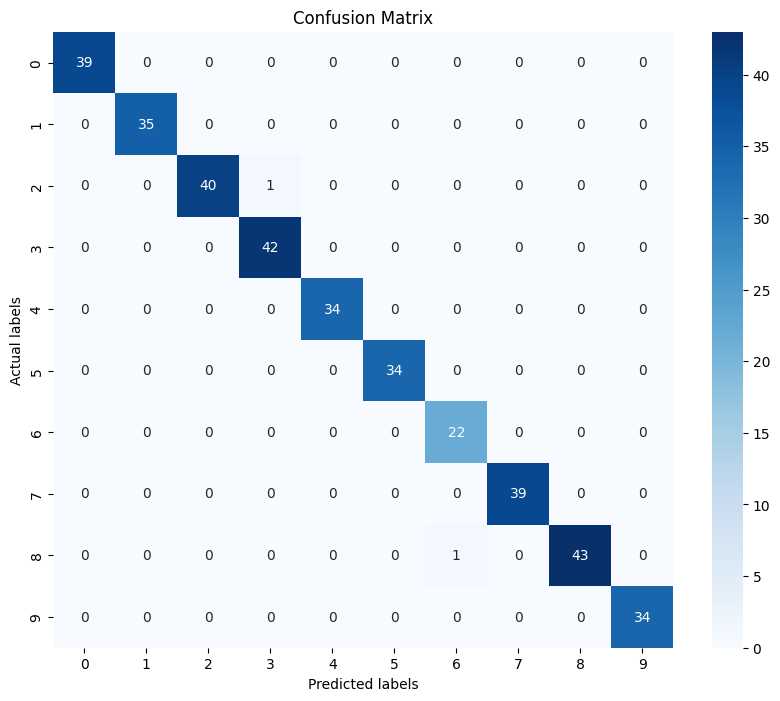

In [122]:
y_pred_probs = model.predict(X_test_res)

y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes))

# Log loss
loss = log_loss(y_test, y_pred_probs)
print(f"Log loss: {loss:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

In [123]:
import joblib

filename = 'CNN_Model.sav'
joblib.dump(model, filename)

['CNN_Model.sav']